# Exercise 1, problem 4.

### Step 1
Given the problem
$$
-u_{xx}+u_x = f, \qquad u(0)=g0, \quad u(1)= g1. 
$$

In this case:
$$
Lu = -u_{xx} + u_x, \quad \Omega = (0,1)
$$
and (2) in the exercises is simply the boundary conditions as given. 

### Step 2 (discretisation)
We choose an equidistibuted grid, that is $x_m = mh$, $m=0,1,\dotsc,M$ with stepsize (or gridsize) $h=1/M$. 
In each gridpoint $x_m$, let $U_m\approx u(x_m)$, replace the derivatives with the second order central difference operators (they are of order 2). The result is

$$
L_h U_m = -\frac{1}{h^2}(U_{m-1}-2U_m+U_{m+1}) + \frac{1}{2h}(U_{m+1}-U_{m-1}) = f(x_m), \qquad m=1,2,\dotsc,M-1
$$

and with $U_0=g_0$ and $U_M = g_1$. 

### Step 3 Implementation and testing.

Import libraries, etc. Here is also a function for constructing tridiagonal matrices included. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

# Auxiliary function.
def tridiag(v, d, w, N):
    # 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

To keep all information about the BVP at one place, it may be convenient to make a class. In this class, also the exact solution can (but do not have to) be provided. It is convenient for testing and convergence plots.

In [2]:
# A class to hold the parameters of the BVP
# -u'' + u' = f, on (a,b), u(a)=ga, u(b) = gb, with Dirichlet boundary conditions
class BVP(object): 
    def __init__(self, f, ga=0, gb=0, a=0, b=1, uexact=None):
        self.f = f       # Source function
        self.ga = ga     # Left boundary condition
        self.gb = gb     # Right boundary condition
        self.a = a       # Interval
        self.b = b
        self.uexact = uexact # The exact solution, if known. 

Make a proper test problem. To test that our implementation is correct, it may be an idea to start with a problem for which the exact solution $u\in \mathbb{P}_3$, as this will be solved exactly. (Why)?

So let us try $u(x)=x^2$, which is the solution of the BVP with
$$
f(x) = -2+2x, \qquad u(0)=0,\quad u(1)=1.
$$

In [3]:
# Make a test problem: 
def f(x):
    return 2*(x-1)
def uexact(x):
    return x**2

example_1 = BVP(f, ga=0, gb=1, a=0, b=1, uexact=uexact)  

The difference formula can be expressed as a system of linear equations $A_hU = F_h$, where in our case
$$
  A_h = \frac{1}{h^2}\text{tridiag}\{-1-\frac{h}{2}, 2, -1+\frac{h}{2}\} \in \mathbb{R}^{(M-1)\times(M-1)}
$$
and 
$$ 
F_{h} = \big[f(x_1)+\frac{1}{h^2}(1+\frac{h}{2}), f(x_2), \cdots, f(x_{M-1})+\frac{1}{h^2}(1-\frac{h}{2})\big]^{\top} \in \mathbb{R}^{M-1}.
$$
Notice that $A_h$ is not symmetric, but it is diagonal dominant (why) with two strict inequalities (the first and the last line), so it is invertible, and there is a unique discrete solution $U$. 

In the implementation, the equations are multiplied by $h^2$ on both sides. 
Also, the boundary conditions are included directly in the linear system, it makes it easier to modify the code for other choises of boundary conditions. This deviates a bit from what was done in the lecture. 

In [4]:
# Implementation of the finite differene scheme above. 
def solve_bvp(bvp, M=10):
    x = np.linspace(bvp.a, bvp.b, M+1)      # Gridpoints, including boundary points
    h = (bvp.b-bvp.a)/M                     # Stepsize

    A = tridiag(-1-0.5*h, 2,-1+0.5*h, M+1)
    F = bvp.f(x)*h**2
    
    # Modify the first and the last rows, to include BC
    A[0,0]=1
    A[0,1]=0
    F[0] = bvp.ga
    A[M,M-1]=0
    A[M,M]=1
    F[M] = bvp.gb

    # Solve the system of linear equations
    U = np.linalg.solve(A,F)
    return x,U

Test the implementation on the very simple test problem given above. 
Check that this particular problem is solved exactly, as expected. 

In [5]:
x, U = solve_bvp(example_1, M=10)
error = example_1.uexact(x)-U
Eh = np.linalg.norm(error,ord=np.inf)   # Use the max-norm
print('The error is {:.2e}'.format(Eh))

The error is 3.33e-16


Now play around a bit with different test problems, both simple and more complicated, and with different stepsizes. This is left to you!

### Step 4 (error analysis)
#### Consistency: 
Using Taylor expansions (or the results from Problem 2 in the exercise), we get

$$
L_h u_m = -\frac{1}{h^2}(u_{m-1}-2u_m+u_{m+1}) + \frac{1}{2h}(u_{m+1}-u_{m-1}) = -\partial_x^2u_m + \partial_xu_m +\big(-\frac{u_{4x}}{24}(\xi_1)+\frac{u_{3x}}{6}(\xi_2)\big)h^2. 
$$

So

$$
L_h u_m = f_m + \tau_m, \qquad m=1,\dotsc,M-1, 
$$

with truncation error $\tau_m = \big(-\frac{u_{4x}}{24}(\xi_1)+\frac{u_{3x}}{6}(\xi_2)\big)h^2$, so given that $u\in C^4(0,1)$, there is a constant $C>0$ such that $|\tau_m|\leq Ch^2$ for all $m$
And obviously, $\tau_m \rightarrow 0$ as $h\rightarrow 0$, so the method is consistent. 
The $C$ can e.g. be 

$$
C = \frac{1}{24}\max_{x\in[0,1]}|u_{4x}|+\frac{1}{6}\max_{x\in[0,1]}|u_{3x}|
$$

#### Convergence:
The next step is to find a bound for the global error $e_m = u_m-U_m$. Since $L_h$ is a linear difference operator we immediatly get that 

$$
L_h e_m = \tau_m.
$$

The difference operator $L_h$ complies with the difference operator on the left hand side of the operator in the inequality of the discrete maximum principle of Problem 3, with

$$
h^2\alpha = 1+h/2,\quad h^2\beta = 2, \quad h^2\gamma=1-h/2,
$$

and since $h\leq 1$ by obvious reasons, the required conditions $\alpha,\beta,\gamma >0$ and $\beta \geq \alpha+\gamma$ are satisfied. 
To be able to use the discrete maximum principle we will find some function $\phi$ such that $L_h(\phi_m\pm e_m)\leq 0$. For this, find some $\phi\in\mathbb{P}_2$ with a constant $\phi_{xx}=D>0$ and $\phi_x<0$ on $(0,1)$, for instance $\phi(x)=D\cdot x(x/2-1)$ with $D>0$. Since the difference operators gives exact solutions of the derivatives for second order polynomials, we get that $L_h \phi_m = -\phi_{xx}(x_m)+\phi_x(x_m)$. Let $v_m = \phi_m \pm e_m$, (in the sense, treat $+e_m$ and $-e_m$ separately, but the procedure is the same). 

$$
  L_h v_m = \pm \tau_m - D + \phi_{x}(x_m). 
$$

The last term is always negative by construction of $D$, so by choosing $D=Ch^2$, the bound for $|\tau_m|$, the right hand side is negative, so $L_h v_m \leq 0$ for all $m=1,2\dotsc,M-1$. Thus

$$
v_m \leq \max\{v_0,v_m,0\} = \max\{0,-D,0\}=0 \qquad \Rightarrow \qquad \pm e_m \leq 0-\phi_m=D\cdot(x_m-x_m^2/2),
$$

so $|e_m| \leq \frac{1}{2}D = \frac{1}{2} Ch^2$. In conclusion

$$
\max_{m}|e_m| \leq \frac{1}{12}\hat{C}h^2, \qquad  \hat{C} = \frac{1}{4}\max_{x\in[0,1]}|u_{4x}|+\max_{x\in[0,1]}|u_{3x}|
$$

and the method is convergent of order 2. 

### Step 5 (verification of theoretical results, in this case convergence)

In [14]:
def convergence(bvp, solver=solve_bvp): 
    # Measure the error for different stepsizes. 
    # Require bvp.uexact to be set. 
    P = 8   # Number of different stepsizes
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 10  # The least number of intervals
    for p in range(P):
        x, U = solver(bvp, M=M)
        Eh = bvp.uexact(x)-U
        Econv[p] = np.max(np.abs(Eh))
        Hconv[p] = x[1]-x[0]
        M = 2*M  # Double the number of intervals (or )
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]   # Measure the order
    return Hconv, Econv, order

Now choose a nice test problem. It should not be too trivial, but the exact solution should be known. 
Here, the problem is adapted to the exact solution $u(x)=x\cdot e^x$. 
According to the result above, this would then give an upper bound for the error of $7/16\cdot e^1\cdot h^2$ (please check this yourself). 

In [23]:
# Make a test problem: 
def f(x):
    return -np.exp(x)
def uexact(x):
    return x*np.exp(x)

example_2 = BVP(f, ga=0, gb=np.exp(1), a=0, b=1, uexact=uexact)  

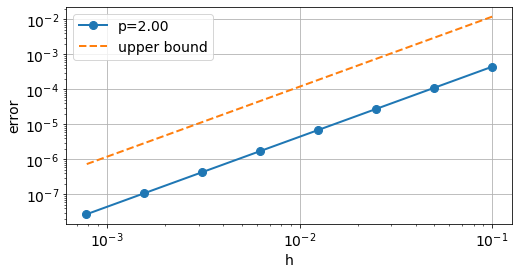

In [24]:
H, E, p = convergence(example_2, solve_bvp)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.loglog(H,H**2*7/16*np.exp(1),'--',label='upper bound')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

And the convergence plot veriefies the theoretical order, the error bound is certainly an upper bound. 